In [1]:
# File: deepfake_detection_transfer_learning
# Name: Yu-Ju Fang 
"""
This dataset consists of about 4k REAL faces from the Flickr dataset collected by Nvidia, 
as well as 4k fake faces sampled from the 1 Million FAKE faces (generated by StyleGAN) 
that was provided by Bojan.

By using data augentation, Transfer Learing(Resnet) to achieve about 94% accuracy of distinguishing 
whether the input image is real face or fake face generated by StyleGAN
"""

'\nThis dataset consists of about 4k REAL faces from the Flickr dataset collected by Nvidia, \nas well as 4k fake faces sampled from the 1 Million FAKE faces (generated by StyleGAN) \nthat was provided by Bojan.\n\nBy using data augentation, Transfer Learing(Resnet) to achieve about 98.5% accuracy of distinguishing \nwhether the input image is real face or fake face generated by StyleGAN\n'

In [2]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
# Please enter the address of the file
FOLDERNAME = 'Colab\ Notebooks/Deepfake_detection'
assert FOLDERNAME is not None, "[!] Enter the foldername."

In [4]:
%cd drive/MyDrive/$FOLDERNAME
BATCH_SIZE = 64

/content/drive/MyDrive/Colab Notebooks/Deepfake_detection


In [5]:
# See if GPU is available
# To turn GPU on: Edit -> Notebook Setting -> GPU
import torch
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [6]:
# Calculate the mean/std for Training Dataset
# You will see the mean/std of your data at the end of this cell
"""
import torchvision.datasets as dset
from torch.utils.data import DataLoader
import torchvision.transforms as T

transform = T.Compose([T.Resize((256, 256)), T.ToTensor()])
training_set = dset.ImageFolder('train1/', transform=transform)
train_loader = DataLoader(training_set, batch_size=len(training_set))
images, labels = next(iter(train_loader))
mean = images.mean()
std = images.std()
"""

"\nimport torchvision.datasets as dset\nfrom torch.utils.data import DataLoader\nimport torchvision.transforms as T\n\ntransform = T.Compose([T.Resize((256, 256)), T.ToTensor()])\ntraining_set = dset.ImageFolder('train1/', transform=transform)\ntrain_loader = DataLoader(training_set, batch_size=len(training_set))\nimages, labels = next(iter(train_loader))\nmean = images.mean()\nstd = images.std()\n"

### There will be five steps to train a Deepake image detection model
1. Load datasets and data preprocessing
2. Define Convolutional Neural Network
3. Define Loss function and optimizer
4. Define and train the network on the training data
5. Test the network on the test data


# 1. Load datasets and data preprocessing

In [7]:
mean = torch.tensor(0.4451)
std = torch.tensor(0.2706)
# Data Pre-processing by PyTorch
import torchvision.transforms as T

In [8]:
transform = T.Compose([T.Resize((256, 256)), T.ToTensor(), T.RandomHorizontalFlip(), T.Normalize(mean=mean, std=std)])

In [9]:
%ls
# Load Your Data by PyTorch
import torchvision.datasets as dset

deepfake_detection.ipynb                    test/   train/   valid/
deepfake_detection_transfer_learning.ipynb  test1/  train1/  valid1/


In [10]:
train = dset.ImageFolder('train1/', transform = transform)
val = dset.ImageFolder('valid1/', transform = transform)

In [11]:
train

Dataset ImageFolder
    Number of datapoints: 11843
    Root location: train1/
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               RandomHorizontalFlip(p=0.5)
               Normalize(mean=0.44510000944137573, std=0.27059999108314514)
           )

In [12]:
# Create Mini-batches by PyTorch
mini_trains = None
mini_vals = None
from torch.utils.data import DataLoader

In [13]:
mini_trains = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
mini_vals = DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)

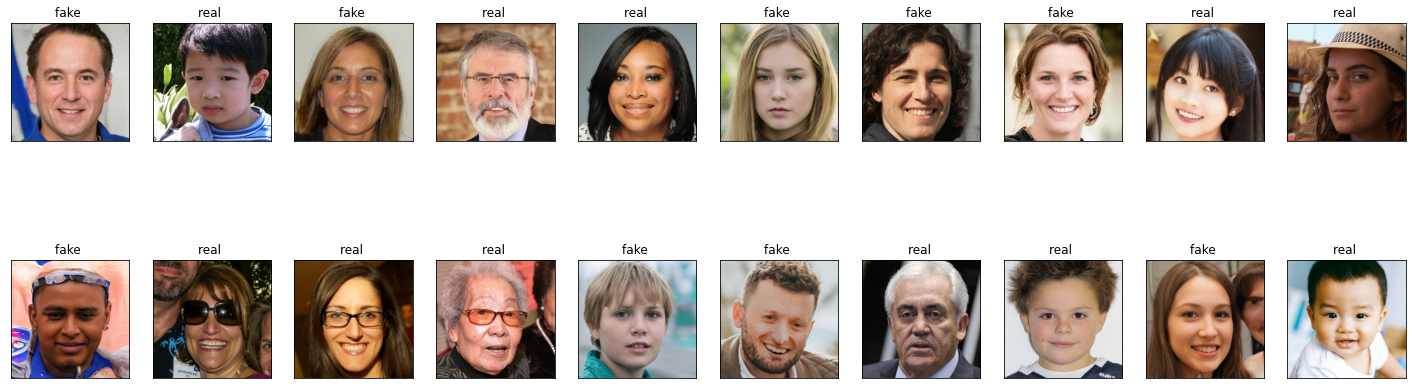

In [14]:
"""
Plot some training data! 
We need to denormalize PyTorch Tensor first, 
and then change it to images with RGB channel
"""

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
classes = ['fake','real']

# Reverse the normalized value to 0-255
def denormalize(image):
  image = T.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) #Changing from 3x224x224 to 224x224x3
  image = torch.clamp(image,0,1)
  return image

# Display an image
def imshow(img):
    img = denormalize(img) 
    plt.imshow(img)

dataiter = iter(mini_trains)
images, labels = dataiter.next()
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ".format( classes[labels[idx]]))

In [15]:
import torch.nn as nn

# 2. Define Convolutional Neural Network by usuing transfer learning

In [16]:
from torchvision import models
import torch.optim as optim
resnet = models.resnet101(pretrained = True).cuda()
num_flatten = resnet.fc.in_features
resnet.fc = nn.Linear(num_flatten, 2)
model = resnet


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

# 3. Define Loss function and optimizer

In [17]:
optimizer = optim.Adam(model.parameters(), lr=1e-5*5)

In [18]:
from torchsummary import summary
summary(model.cuda(), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

# 4. Define and train the network on the training data

In [19]:
def evaluate_predictor(loader, model):
  # Turn on evaluation mode on your model
  model.eval()
  val_loss = 0
  val_acc = 0
  with torch.no_grad():
    for x, y in loader:
      # move tensors to GPU if CUDA is available
      x = x.to(device)
      y = y.to(device)

      # forward pass: compute predicted outputs by passing inputs to the model
      scores = model(x)
      
      # Choose your loss function!
      loss_function = nn.CrossEntropyLoss()
      loss = loss_function(scores, y)

      val_loss += loss.item()*x.size(0)
      prediction = scores.data.max(1)[1]
      acc = prediction.eq(y).sum().item()
      val_acc += acc

    # calculate average losses
    val_loss = val_loss / len(mini_vals.dataset)
    val_acc = val_acc / len(mini_vals.dataset)
    print(f'Loss: {val_loss} / Acc: {val_acc}')
    

In [20]:
def train(model, optimizer, epochs=1):
  for epoch in range(epochs):
    print('----------------------------')
    print('EPOCH: {}'.format(epoch+1))
    for t, (x, y) in enumerate(mini_trains):  
      # Turn on the training mode on your model
      model.train()
      # move tensors to GPU if CUDA is available
      x = x.to(device)
      y = y.to(device)

      # forward pass: compute predicted outputs by passing inputs to the model
      scores = model(x)
      
      # calculate the batch loss
      # Choose your loss function!
      loss_function = nn.CrossEntropyLoss()
      loss = loss_function(scores, y)

      # clear the gradients of all optimized variables
      optimizer.zero_grad()

      loss.backward()

      # perform a single optimization step (parameter update)
      optimizer.step()

      if t % 7 == 0:
        print('Iteration %d, loss = %.4f' % (t, loss.item()))
        evaluate_predictor(mini_vals, model)

In [21]:
train(model, optimizer, epochs=10)

----------------------------
EPOCH: 1
Iteration 0, loss = 0.6918
Loss: 0.7150216975989299 / Acc: 0.5088757396449705
Iteration 7, loss = 0.4864
Loss: 0.6195445332942694 / Acc: 0.6401291016675632
Iteration 14, loss = 0.3541
Loss: 0.4806730773354038 / Acc: 0.7692307692307693
Iteration 21, loss = 0.2928
Loss: 0.7251480884485312 / Acc: 0.6546530392684239
Iteration 28, loss = 0.3619
Loss: 0.4682653580319824 / Acc: 0.78375470683163
Iteration 35, loss = 0.2191
Loss: 0.3784149161040494 / Acc: 0.8208714362560516
Iteration 42, loss = 0.3435
Loss: 0.28999101835082075 / Acc: 0.8719741796664874
Iteration 49, loss = 0.2670
Loss: 0.2611506718214383 / Acc: 0.8891877353415815
Iteration 56, loss = 0.2865
Loss: 0.27869484375515025 / Acc: 0.8735879505110274
Iteration 63, loss = 0.3435
Loss: 0.31295406530626746 / Acc: 0.8649811726734804
Iteration 70, loss = 0.2389
Loss: 0.2719829020437581 / Acc: 0.8795051102743411
Iteration 77, loss = 0.2408
Loss: 0.23004743617154244 / Acc: 0.8913394298009683
Iteration 84, 

# 5. Test the network on the test data

In [22]:
test = dset.ImageFolder('test1/', transform = transform)
mini_test = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

In [23]:
def check_accuracy(loader, model):   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [24]:
check_accuracy(mini_test, model)

Got 1679 / 1789 correct (93.85)
